# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications.resnet50 import ResNet50

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [5]:
train_doc[0].strip('\n').split(';')

['WIN_20180926_16_54_08_Pro_Right_Swipe_new', 'Right_Swipe_new', '1']

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
class DataGenerator:
    
    def __init__(self, height, width, channels=3, total_frames = 30, frames_to_skip=1, augment = False):
        self.height = height
        self.width = width
        self.channels = channels
        self.total_frames = total_frames
        self.frames_to_skip = frames_to_skip
        self.augment = augment
    
    def batch_data_label(self, source_path, img_idx, batch_size, batch, t):
        batch_data = np.zeros((batch_size, self.total_frames//self.frames_to_skip, self.height, self.width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

        if (self.augment): 
            batch_data_aug = np.zeros((batch_size,len(img_idx),self.height,self.width,self.channels))
        
        for folder in range(batch_size): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#             print("folder: ", folder+(batch*batch_size))
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                image_resized = resize(image,(self.height,self.width,3))
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,0])/255
                
                if (self.augment):
                    
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    # Convert images to gray
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    # Crop the converted images
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(image,(self.height,self.width,3))
                    
                    # Rotate images a little bit to take care of the possibility of rotation in real world
                    M = cv2.getRotationMatrix2D((self.width//2,self.height//2), np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.height, self.width))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (self.augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
            
        return batch_data, batch_labels 
        
    def get_num_batches(self, folder_list, batch_size):
        return len(folder_list)//batch_size
    
    def generator(self, source_path, folder_list, batch_size=50):
#         print( 'Source path = ', source_path, '; batch size =', batch_size)
        img_idx = [x for x in range(0, self.total_frames, self.frames_to_skip)]
        while True:
            t = np.random.permutation(folder_list)
            num_batches = self.get_num_batches(folder_list, batch_size)
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels = self.batch_data_label(source_path, img_idx, batch_size, batch, t)
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            # write the code for the remaining data points which are left after full batches
            if(len(t)%batch_size):
                batch_size = len(t) - (batch_size*num_batches)
                batch_data, batch_labels = self.batch_data_label(source_path, img_idx, batch_size, num_batches, t)
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Training Model


In [7]:
def train_model(model, train_generator, val_generator, batch_size, num_epochs, optimiser = None):
    curr_dt_time = datetime.datetime.now()
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs)
    print('# batch size =', batch_size)
    
    # Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.
    if optimiser == None:
        optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
    callbacks_list = [checkpoint, LR]
    
    # The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    print("\nTime Taken to run this model: ", datetime.datetime.now()-curr_dt_time)
    return history

In [8]:
def plot_val_acc(history):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    # Plot history: Categorical crossentropy & Accuracy
    plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
    plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
    plt.title('Model performance')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Accuracy (training data)')
    plt.plot(history.history['val_categorical_accuracy'], label='Accuracy (validation data)')
    plt.title('Model performance')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc='upper left')
    plt.show()

In [9]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Model

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [19]:
#write your model here

class ModelGeneratorCNN3D():
    
    '''
    Reference - http://cs231n.stanford.edu/slides/2018/cs231n_2018_ds08.pdf
    Architecture based on https://arxiv.org/pdf/1412.0767.pdf 
    [Learning Spatiotemporal Features with 3D Convolutional Networks]
    '''
    def CNN3D_V1(self, input_shape):
        model = Sequential()
        model.add(Conv3D(64, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V2(self, input_shape):
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (1, 1, 1)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V3(self, input_shape):
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V4(self, input_shape):
        model = Sequential()
        model.add(Conv3D(64, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(128, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (1, 1, 1)))
        
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))
        return model
     
    def CNN3D_V5(self, input_shape):
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V6(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V7(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V8(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V9(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(5, activation='softmax'))
        return model
    
    '''
    momentum: Momentum for the moving average in batch normalization.
    Reason for batchnormalization overfitting the model can be that the validation data does not have same average as training data so we will use momentum of 0.8
    in batchnormalization.
    '''
    def CNN3D_V10(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Dense(5, activation='softmax'))
        return model
    
    '''
    We will also add regularization.
    '''
    
    def CNN3D_V11(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
        model.add(Activation('relu')) 
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.20))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V12(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN3D_V13(self, input_shape):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), input_shape=input_shape, padding='valid'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1, 2, 2)))
        
        model.add(Conv3D(32, (3, 3, 3), padding='valid'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Conv3D(64, (3, 3, 3), padding='valid'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))
        return model

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

### Model 1

1st architecture which is loosely based on https://arxiv.org/pdf/1412.0767.pdf

In [11]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [11]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [12]:
input_shape = (30, 100, 100, 3)

# Number of epochs = 20, as training sequence = 663 and batch size = 32, so number of epochs = 663/32 = ~20
model = model_gen.CNN3D_V1(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 28, 98, 98, 64)    5248      
_________________________________________________________________
activation (Activation)      (None, 28, 98, 98, 64)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 28, 49, 49, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 26, 47, 47, 128)   221312    
_________________________________________________________________
activation_1 (Activation)    (None, 26, 47, 47, 128)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 13, 23, 23, 128)   0         
__________________________________

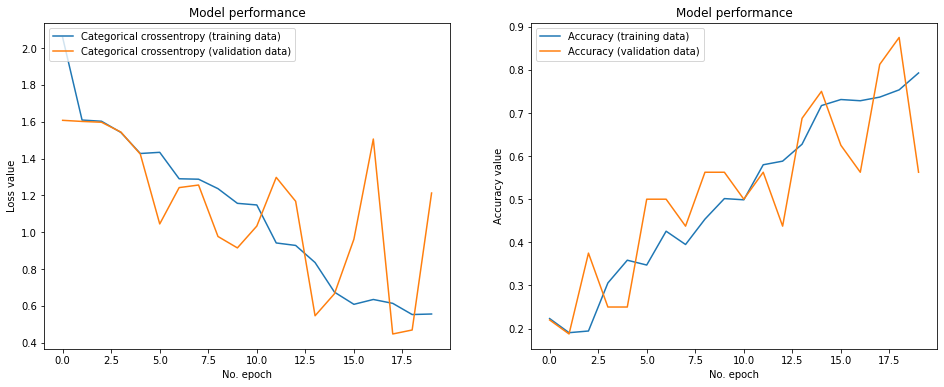

In [13]:
plot_val_acc(history)

### Model 2

Increase the number of maxpooling and conv layers to test whether we can achieve better accuracy or not

In [14]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [15]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [16]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V2(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 28, 98, 98, 32)    2624      
_________________________________________________________________
activation_3 (Activation)    (None, 28, 98, 98, 32)    0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 28, 49, 49, 32)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 26, 47, 47, 64)    55360     
_________________________________________________________________
activation_4 (Activation)    (None, 26, 47, 47, 64)    0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 13, 23, 23, 64)    0         
________________________________

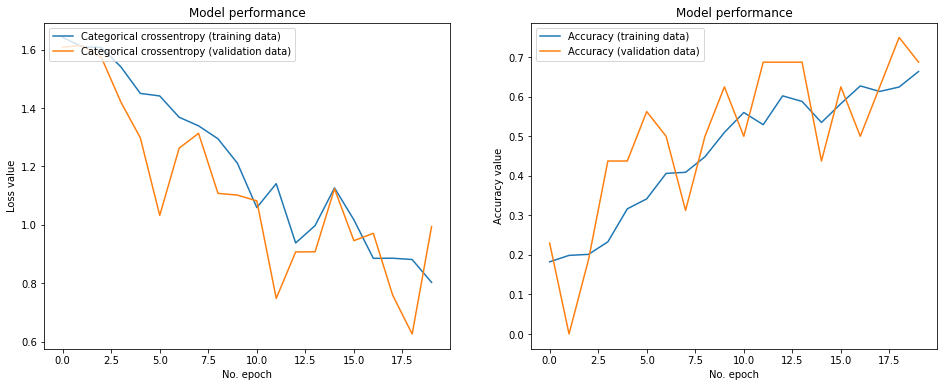

In [17]:
plot_val_acc(history)

### Model 3

Decreased the number of kernels in conv layer but increased the number of dense neurons based on model 2.

In [18]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [19]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [20]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V3(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 28, 98, 98, 32)    2624      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 98, 98, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 28, 49, 49, 32)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 26, 47, 47, 64)    55360     
_________________________________________________________________
activation_8 (Activation)    (None, 26, 47, 47, 64)    0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 13, 23, 23, 64)    0         
________________________________

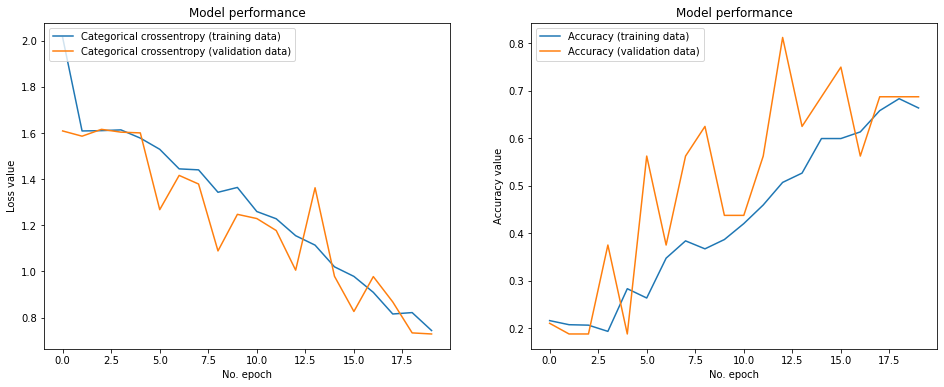

In [21]:
plot_val_acc(history)

### Model 4

Add more layers on our previous model

In [27]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [28]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [29]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V4(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 28, 98, 98, 64)    5248      
_________________________________________________________________
activation_14 (Activation)   (None, 28, 98, 98, 64)    0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 28, 49, 49, 64)    0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 26, 47, 47, 128)   221312    
_________________________________________________________________
activation_15 (Activation)   (None, 26, 47, 47, 128)   0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 13, 23, 23, 128)   0         
________________________________

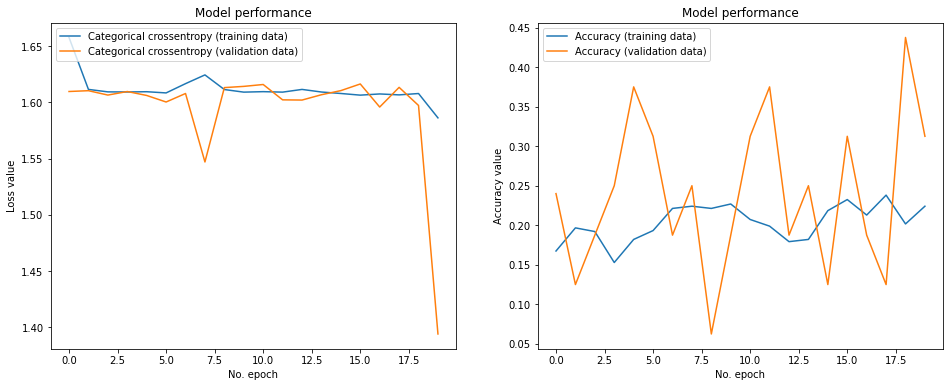

In [30]:
plot_val_acc(history)

### Model 5

Reduced the number of layers.

In [35]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [36]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [37]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V5(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 28, 98, 98, 32)    2624      
_________________________________________________________________
activation_22 (Activation)   (None, 28, 98, 98, 32)    0         
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 28, 49, 49, 32)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 26, 47, 47, 64)    55360     
_________________________________________________________________
activation_23 (Activation)   (None, 26, 47, 47, 64)    0         
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 13, 23, 23, 64)    0         
________________________________

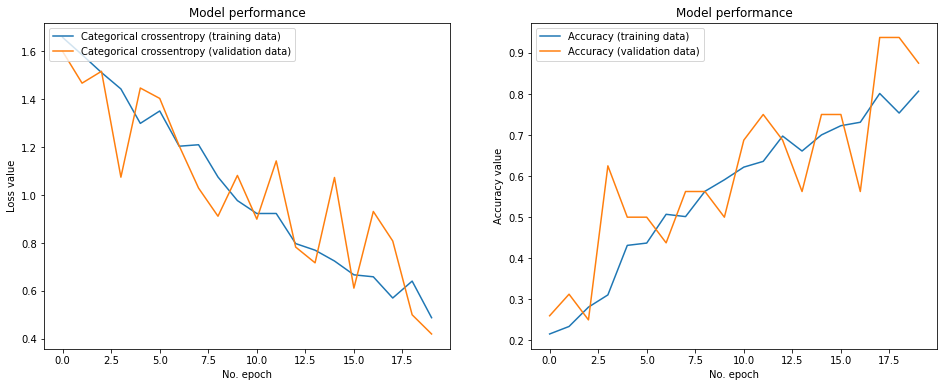

In [38]:
plot_val_acc(history)

### Model 6

Reduced the number of parameters in our model compared to model 1.

In [43]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [44]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [45]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V6(input_shape)

history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 25)

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch size = 32
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation_28 (Activation)   (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 26, 47, 47, 32)    13856     
_________________________________________________________________
activation_29 (Activation)   (None, 26, 47, 47, 32)    0         
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 13, 23, 23, 32)    0         
________________________________

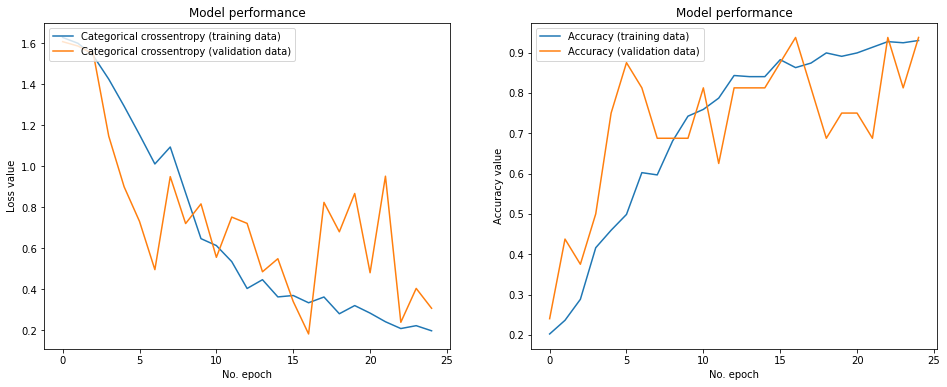

In [46]:
plot_val_acc(history)

### Model 6.1

Increased batch size to see  the effect in training

In [19]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [20]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 64

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [21]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V6(input_shape)

history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 15, optimiser=optimizers.Adam(0.001))

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size = 64
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation_9 (Activation)    (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 26, 47, 47, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 26, 47, 47, 32)    0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 13, 23, 23, 32)    0         
________________________________

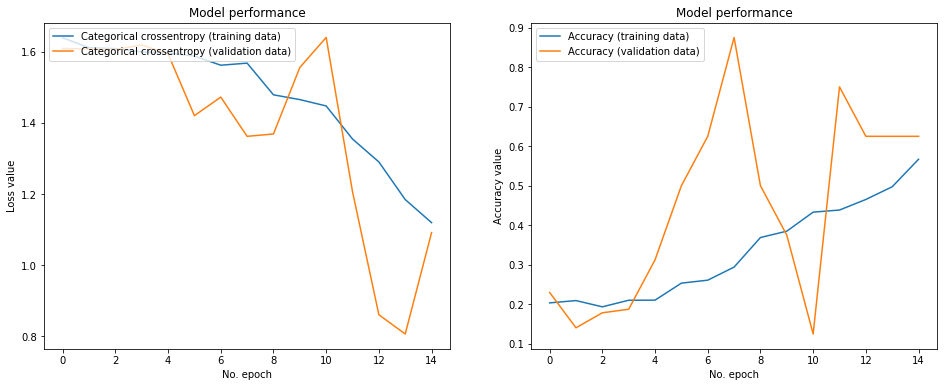

In [22]:
plot_val_acc(history)

Reason to choose batch size = 32:
1. High batch size learns together with same learning rate so steps are also less for improvement.If we increase loss function to compensate the batch size then we will not be able to achieve better accuracy as training loss will start to oscillate in that case. 
2. Increasing batch size will decrease the number of steps in validation
So now on we will choose batch size = 32

### Model 6.2

In [11]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [12]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [13]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V6(input_shape)

history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 25, optimiser = optimizers.SGD())

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch size = 32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation (Activation)      (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 26, 47, 47, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 26, 47, 47, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 13, 23, 23, 32)    0         
__________________________________

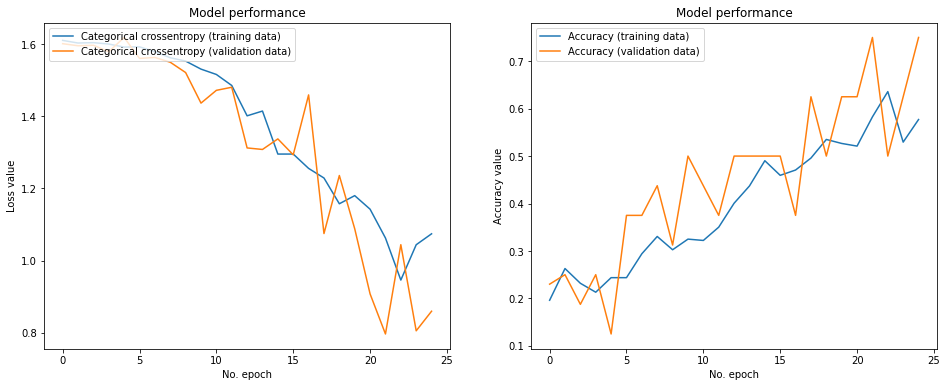

In [14]:
plot_val_acc(history)

### Model 7

Added dropout layers in model 6.

In [19]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [20]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [21]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V7(input_shape)

history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation_9 (Activation)    (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 26, 47, 47, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 26, 47, 47, 32)    0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 13, 23, 23, 32)    0         
________________________________

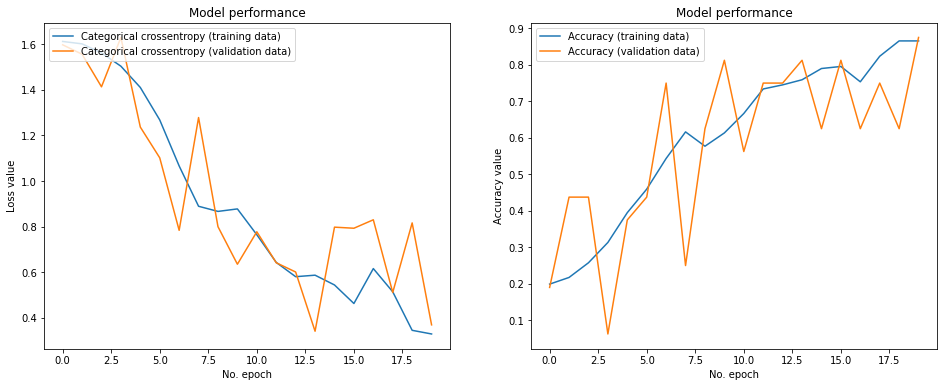

In [22]:
plot_val_acc(history)

### Model 8

Added batch normalization on model. This model is based on model 6.

In [23]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [24]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [25]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V8(input_shape)

history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation_13 (Activation)   (None, 28, 98, 98, 16)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 98, 98, 16)    64        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 26, 47, 47, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 26, 47, 47, 32)    0         
________________________________

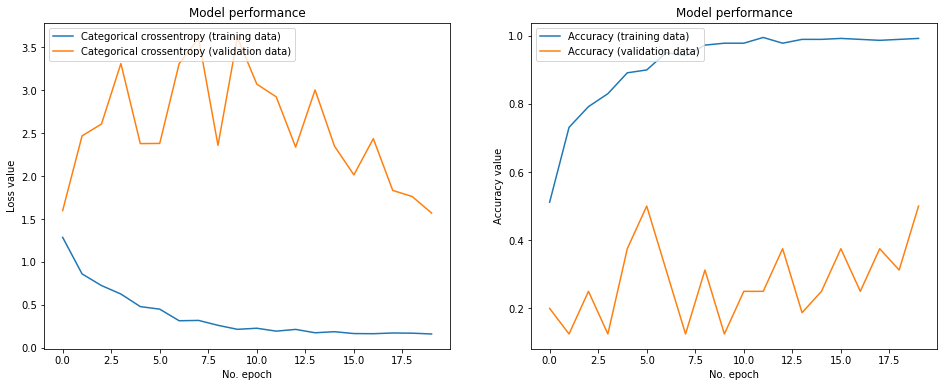

In [26]:
plot_val_acc(history)

### Model 9

Increased the number of dropout layers. Applied dropout layers after conv layers as well.

In [41]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [42]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [43]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V9(input_shape)

history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation_23 (Activation)   (None, 28, 98, 98, 16)    0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 98, 98, 16)    64        
_________________________________________________________________
dropout_11 (Dropout)         (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 26, 47, 47, 32)    13856     
________________________________

KeyboardInterrupt: 

In [ ]:
plot_val_acc(history)

### Model 10

Added momentum = 0.8 in batch normalisation in model 9.

In [25]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [26]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [27]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V10(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 25)

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch size = 32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation (Activation)      (None, 28, 98, 98, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 98, 98, 16)    64        
_________________________________________________________________
dropout (Dropout)            (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 26, 47, 47, 32)    13856     
________________________________

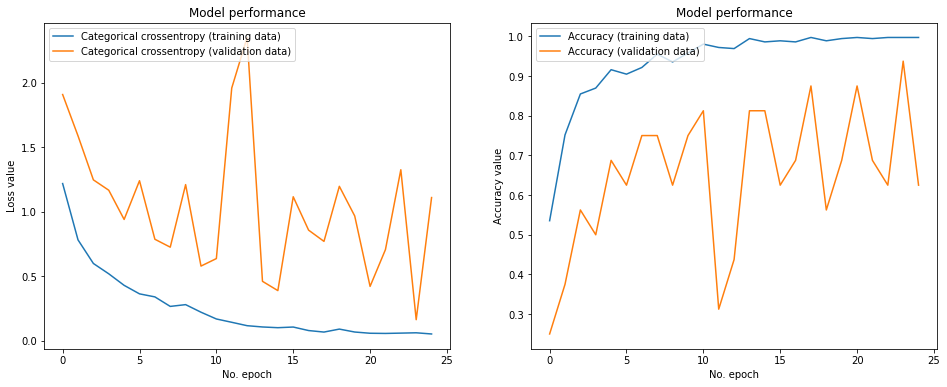

In [28]:
plot_val_acc(history)

### Model 11

Added kernel regularizers in 2 conv layers in dense layers with factor value of 0.01

In [12]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [13]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [14]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN3D_V11(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation (Activation)      (None, 28, 98, 98, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 98, 98, 16)    64        
_________________________________________________________________
dropout (Dropout)            (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 26, 47, 47, 32)    13856     
__________________________________

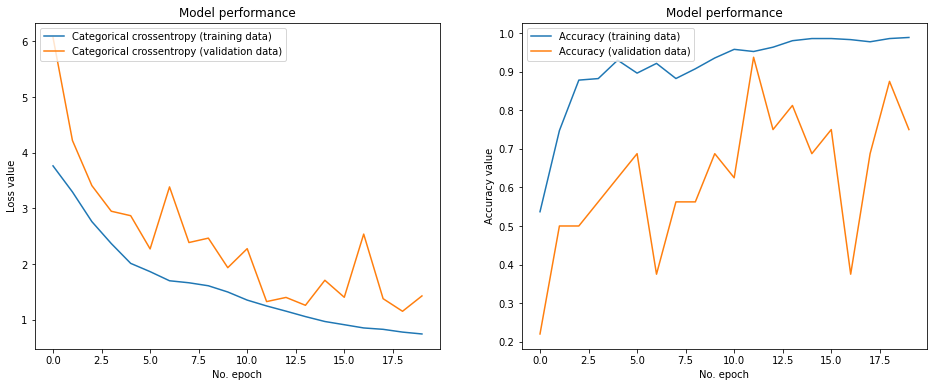

In [15]:
plot_val_acc(history)

### Model 12

Model based on model **11**(As it gave us the best accuracy). Added the augmented images in training.

In [16]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [17]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1, augment=True)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [18]:
input_shape = (30, 100, 100, 3)

# Number of epochs = 20, as training sequence = 663*2(due to augmentation data) and batch size = 32, so number of epochs = 663*2/32 = ~40
model = model_gen.CNN3D_V11(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 30)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch size = 32
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 28, 98, 98, 16)    1312      
_________________________________________________________________
activation_5 (Activation)    (None, 28, 98, 98, 16)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 98, 98, 16)    64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 98, 98, 16)    0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 28, 49, 49, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 26, 47, 47, 32)    13856     
________________________________

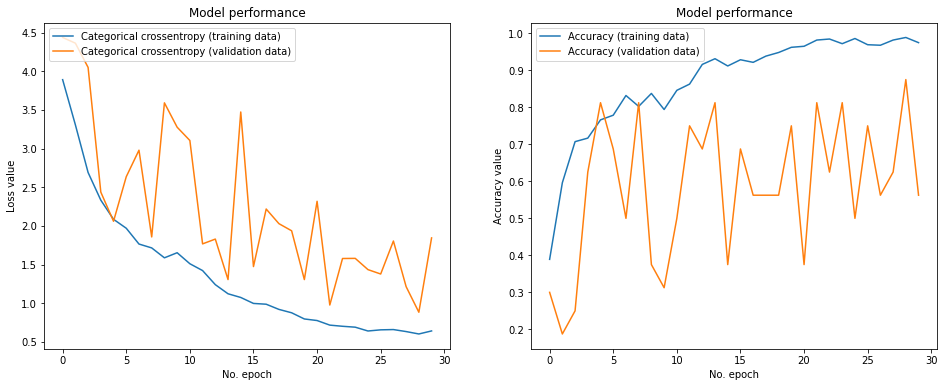

In [19]:
plot_val_acc(history)

### Model 13

Model based on model **6**(As it gave us the best accuracy). Increase the size of images from (100, 100, 3) to (120, 120, 3)

In [20]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [21]:
train_gen = DataGenerator(height=120, width=120, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=120, width=120, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN3D()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [22]:
input_shape = (30, 120, 120, 3)

model = model_gen.CNN3D_V6(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 28, 118, 118, 16)  1312      
_________________________________________________________________
activation_10 (Activation)   (None, 28, 118, 118, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 28, 59, 59, 16)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 26, 57, 57, 32)    13856     
_________________________________________________________________
activation_11 (Activation)   (None, 26, 57, 57, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 13, 28, 28, 32)    0         
________________________________

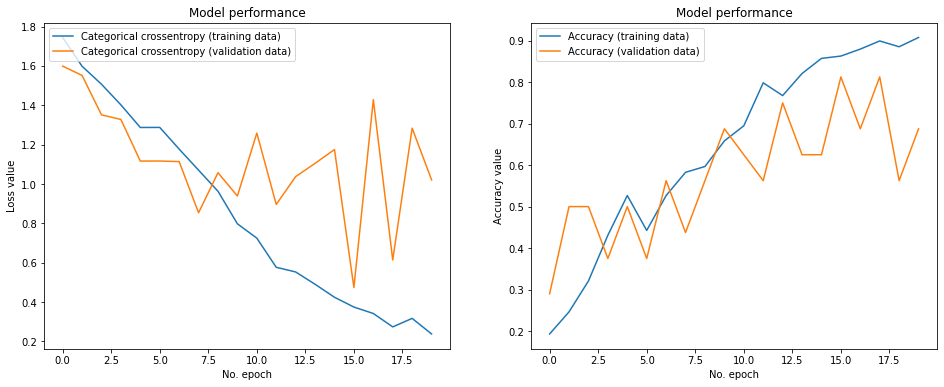

In [23]:
plot_val_acc(history)

# Model CNN + RNN

In [1]:

class ModelGeneratorCNN_RNN:
    
    def CNN_RNN_V1(self, input_shape, lstm_cells = 64, dense_neurons=64):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dropout(0.25))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(0.25))
        
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN_RNN_V2(self, input_shape, lstm_cells = 64, dense_neurons=64):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dense(dense_neurons,activation='relu'))
        
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN_RNN_TL_V1(self, input_shape):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(64))
        
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(5, activation='softmax'))
        return model
    
    
    def CNN_RNN_TL_V2(self, input_shape):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128, return_sequences=True))
        
        model.add(GRU(64))
        
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(32,activation='relu'))
        
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN_RNN_TL_V3(self, input_shape):
        resnet = ResNet50(weights="imagenet", include_top=False,)
        
        model = Sequential()
        model.add(TimeDistributed(resnet,input_shape=input_shape))
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128, return_sequences=True))
        
        model.add(GRU(64))
        
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(32,activation='relu'))
        
        model.add(Dense(5, activation='softmax'))
        return model
    
    def CNN_RNN_TL_V4(self, input_shape):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128, return_sequences=True))
        model.add(Dropout(0.20))
        model.add(GRU(64))
        model.add(Dropout(0.20))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.20))
        model.add(Dense(32,activation='relu'))
        
        model.add(Dense(5, activation='softmax'))
        return model
    

### Model 14

CNN + GRU model. (Used GRU model as it performs similar to LSTM but training time is low)

In [52]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [53]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN_RNN()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [54]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN_RNN_V1(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 25, 25, 32)    0         
________________________________

KeyboardInterrupt: 

In [ ]:
plot_val_acc(history)

### Model 15

Model build by using features vectors from mobilenet and passing them through 2 GRU layer. (Used GRU model as it performs similar to LSTM but training time is low)

In [68]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [69]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN_RNN()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [70]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN_RNN_V2(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_31 (TimeDis (None, 30, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_32 (TimeDis (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 30, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 25, 25, 64)    18496     
_________________________________________________________________
time_distributed_36 (TimeDis (None, 30, 12, 12, 64)    0         
_______________________________

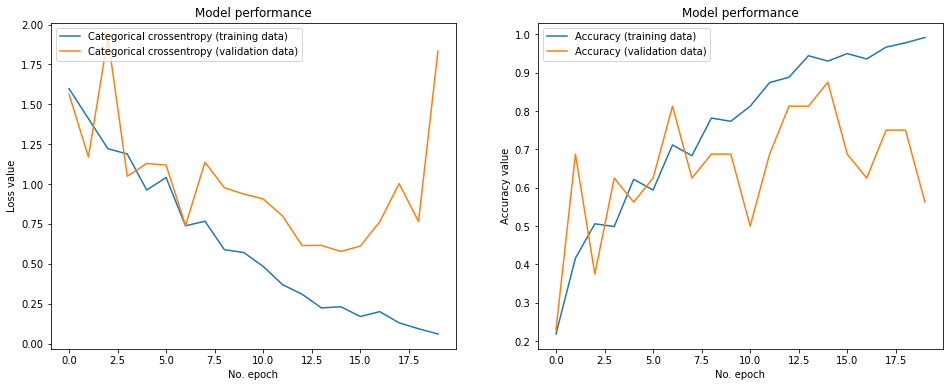

In [71]:
plot_val_acc(history)

### Model 16

Model build by using features vectors from Resnet50 and passing them through GRU layer. (Used GRU model as it performs similar to LSTM but training time is low)

In [73]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [74]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN_RNN()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [75]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN_RNN_TL_V1(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 20)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 32
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_41 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 325       
Total params: 3,442,629
Trainab

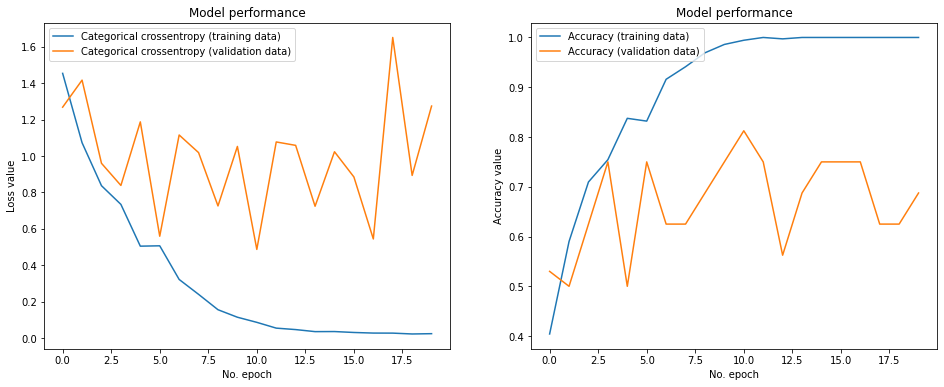

In [76]:
plot_val_acc(history)

### Model 17

Model build by using features vectors from mobilenet and passing them through 2 GRU layer. (Used GRU model as it performs similar to LSTM but training time is low)

In [14]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [15]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN_RNN()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [16]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN_RNN_TL_V2(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 10)

# training sequences = 663
# validation sequences = 100
# epochs = 10
# batch size = 32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 30, 128)           443136    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
__________________________________

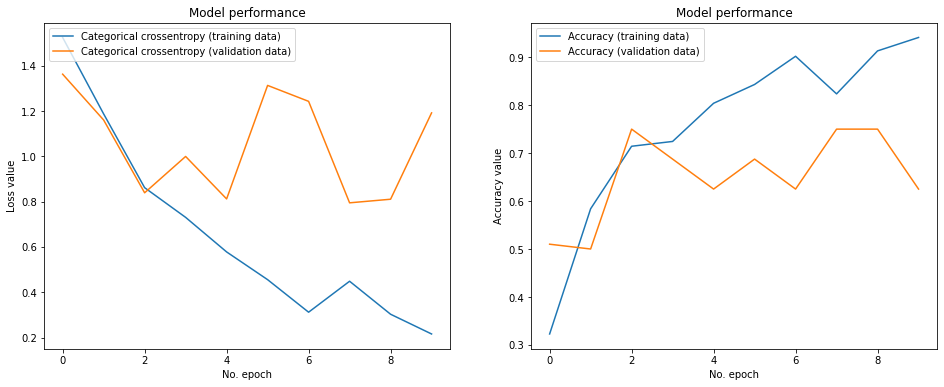

In [17]:
plot_val_acc(history)

### Model 18

Model build by using features vectors from Resnet50 and passing them through GRU layer. (Used GRU model as it performs similar to LSTM but training time is low)

In [18]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [19]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN_RNN()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [20]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN_RNN_TL_V3(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 10)

94773248/94765736 [==============================] - 2s 0us/step
# training sequences = 663
# validation sequences = 100
# epochs = 10
# batch size = 32
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 30, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 2, 2, 2048)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 8192)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 128)           3195648   
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (Non

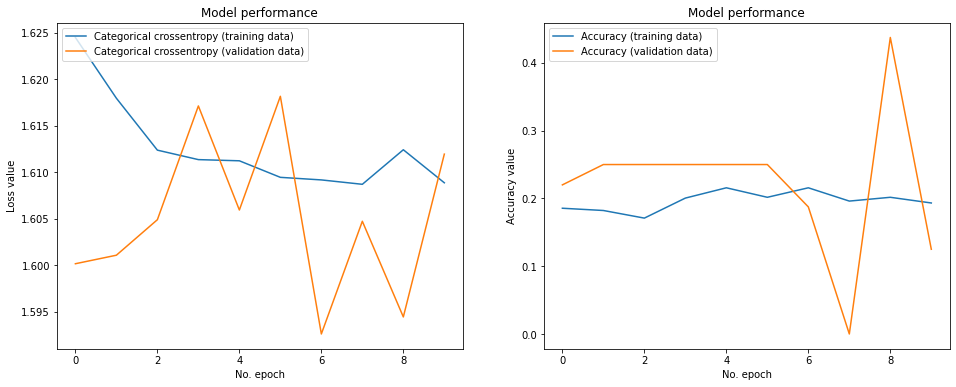

In [21]:
plot_val_acc(history)

### Model 19

Model build by using features vectors from mobilenet and passing them through 2 GRU layer and in between using Dropout layers. (Used GRU model as it performs similar to LSTM but training time is low)

In [25]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [26]:
train_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
val_gen = DataGenerator(height=100, width=100, channels=3, total_frames = 30, frames_to_skip=1)
model_gen = ModelGeneratorCNN_RNN()

batch_size = 32

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

In [27]:
input_shape = (30, 100, 100, 3)

model = model_gen.CNN_RNN_TL_V4(input_shape)
history = train_model(model, train_generator, val_generator, batch_size = batch_size, num_epochs = 10)

# training sequences = 663
# validation sequences = 100
# epochs = 10
# batch size = 32
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 30, 128)           443136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
________________________________

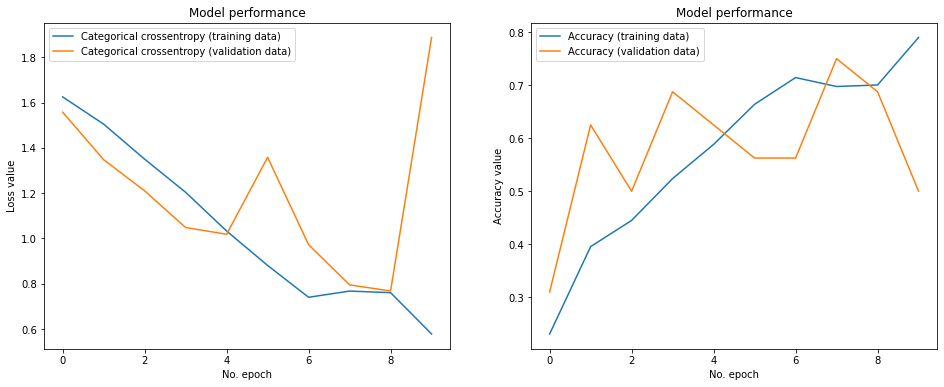

In [28]:
plot_val_acc(history)